<a href="https://colab.research.google.com/github/swilsonmfc/stable-diffusion/blob/main/FGVCAircraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP & FGVC-Aircraft

# Install

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6pb85wxv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6pb85wxv
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=575688a012bfd1732a20fa4ac23de462e0d45f32623f3fbebb4c3870f83a797e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyqicy4u/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Setup

In [3]:
!nvidia-smi

Fri May 19 15:11:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from pkg_resources import packaging

import clip

import skimage
import IPython.display
from PIL import Image

# Data

In [5]:
!wget -O data.tar.gz https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz

--2023-05-19 15:11:12--  https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2753340328 (2.6G) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.56G  31.5MB/s    in 85s     

2023-05-19 15:12:38 (30.9 MB/s) - ‘data.tar.gz’ saved [2753340328/2753340328]



In [ ]:
!gunzip data.tar.gz
!tar -xvf data.tar

# Dataset

In [21]:
df = pd.read_fwf('fgvc-aircraft-2013b/data/images_family_val.txt', 
                 colspecs=[(0, 7), (7, 100)], 
                 header=None,
                 dtype={'image':str},
                 names=['image', 'category'])
df

,image,category
0,0481847,Boeing 707
1,0810608,Boeing 707
2,1514481,Boeing 707
3,0887066,Boeing 707
4,1318819,Boeing 707
...,...,...
3328,1203670,Yak-42
3329,0944182,Yak-42
3330,1340345,Yak-42
3331,0765754,Yak-42


In [10]:
df.category.unique()

array(['Boeing 707', 'Boeing 727', 'Boeing 737', 'Boeing 747',
       'Boeing 757', 'Boeing 767', 'Boeing 777', 'A300', 'A310', 'A320',
       'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146',
       'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47',
       'CRJ-200', 'CRJ-700', 'Cessna 172', 'Cessna 208',
       'Cessna Citation', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6',
       'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'Dash 8', 'DR-400',
       'Dornier 328', 'Embraer E-Jet', 'EMB-120', 'Embraer ERJ 145',
       'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16', 'F/A-18',
       'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'King Air',
       'PA-28', 'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado',
       'Tu-134', 'Tu-154', 'Yak-42'], dtype=object)

# CLIP Model

In [11]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [12]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 134MiB/s]


# Pre-Processor

## Image

In [13]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fad30d3f2e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text

In [15]:
clip.tokenize('Aircraft Classification')

tensor([[49406,  7706, 26612, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Examples

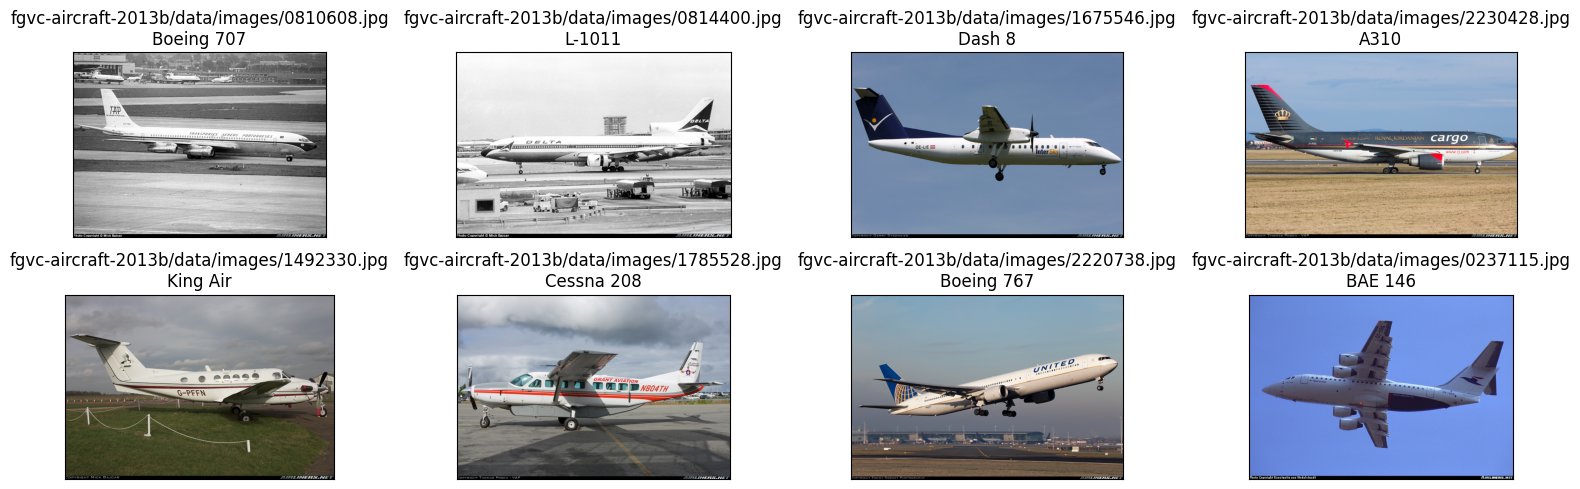

In [31]:
original_images = []
images = []
texts  = []
plt.figure(figsize=(16, 5))

sample_df = df.sample(n=8, random_state=1337)
for _, row in sample_df.iterrows():
  filename = f"fgvc-aircraft-2013b/data/images/{row['image']}.jpg"
  category = row['category']
  image = Image.open(filename).convert("RGB")
  
  plt.subplot(2, 4, len(images) + 1)
  plt.imshow(image)
  plt.title(f"{filename}\n{category}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(preprocess(image))
  texts.append(category)
plt.tight_layout()

# Features

In [57]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(['This is photo of a ' + desc for desc in texts]).cuda()

In [58]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features  = model.encode_text(text_tokens).float()

# Cosine Similarity

In [59]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

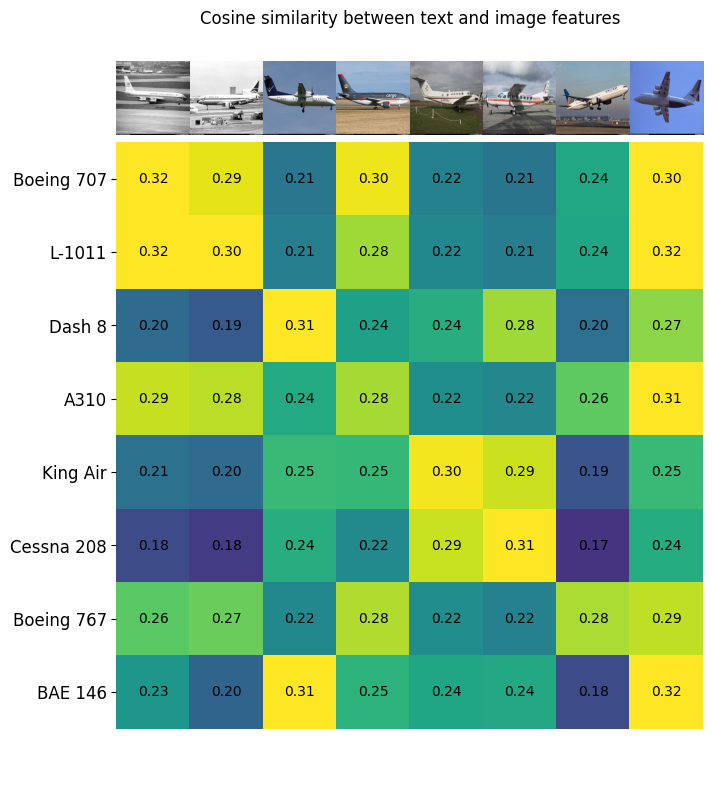

In [66]:
count = len(sample_df.category)

plt.figure(figsize=(12, 10))
plt.imshow(similarity, vmin=0.15, vmax=0.3)
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])

for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center')

for side in ['left', 'top', 'right', 'bottom']:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title('Cosine similarity between text and image features');

# Zero Shot

In [40]:
classifications = list(df.category.unique())

['Boeing 707',
 'Boeing 727',
 'Boeing 737',
 'Boeing 747',
 'Boeing 757',
 'Boeing 767',
 'Boeing 777',
 'A300',
 'A310',
 'A320',
 'A330',
 'A340',
 'A380',
 'ATR-42',
 'ATR-72',
 'An-12',
 'BAE 146',
 'BAE-125',
 'Beechcraft 1900',
 'Boeing 717',
 'C-130',
 'C-47',
 'CRJ-200',
 'CRJ-700',
 'Cessna 172',
 'Cessna 208',
 'Cessna Citation',
 'Challenger 600',
 'DC-10',
 'DC-3',
 'DC-6',
 'DC-8',
 'DC-9',
 'DH-82',
 'DHC-1',
 'DHC-6',
 'Dash 8',
 'DR-400',
 'Dornier 328',
 'Embraer E-Jet',
 'EMB-120',
 'Embraer ERJ 145',
 'Embraer Legacy 600',
 'Eurofighter Typhoon',
 'F-16',
 'F/A-18',
 'Falcon 2000',
 'Falcon 900',
 'Fokker 100',
 'Fokker 50',
 'Fokker 70',
 'Global Express',
 'Gulfstream',
 'Hawk T1',
 'Il-76',
 'L-1011',
 'MD-11',
 'MD-80',
 'MD-90',
 'Metroliner',
 'King Air',
 'PA-28',
 'SR-20',
 'Saab 2000',
 'Saab 340',
 'Spitfire',
 'Tornado',
 'Tu-134',
 'Tu-154',
 'Yak-42']

In [53]:
prompts = [f'This is a photo of a {label} aircraft' for label in classifications]
prompt_tokens = clip.tokenize(prompts).cuda()

In [54]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

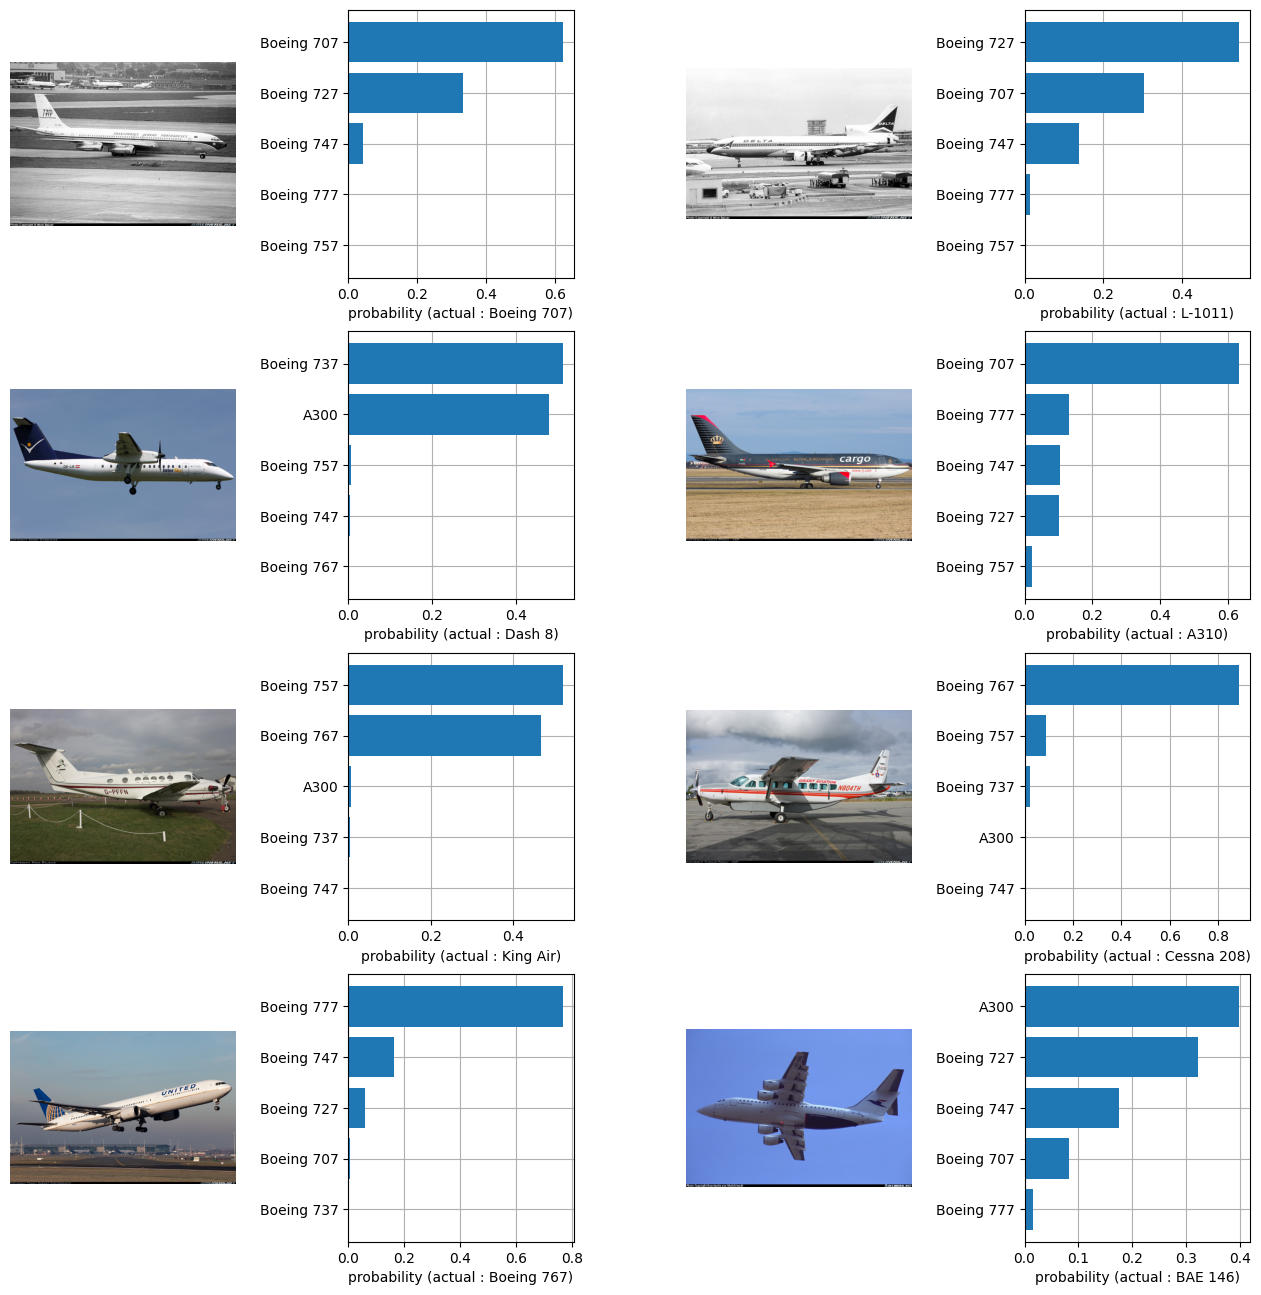

In [56]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classifications[index] for index in top_labels[i].numpy()])
    plt.xlabel(f'probability (actual : {texts[i]})')

plt.subplots_adjust(wspace=0.5)
plt.show()